Praca domowa 5

Autor: Jakub Białek

29.04.2020

In [14]:
import pandas as pd
import numpy as np
import os
from sklearn.inspection import permutation_importance
import shap
import xgboost as xgb
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_curve, \
roc_auc_score, precision_recall_curve, confusion_matrix, r2_score, mean_absolute_error, \
mean_squared_error
from sklearn.inspection import permutation_importance
import pandas_profiling as pp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

In [3]:
pd.options.display.max_columns = 200

In [4]:
!dir data

 Volume in drive C is Windows
 Volume Serial Number is 5441-C8EF

 Directory of C:\Users\bialekj\Documents\Moje\Doktorat wdrozeniowy\wyklady\XAI\pd5\data

29.04.2020  07:26    <DIR>          .
29.04.2020  07:26    <DIR>          ..
22.03.2020  18:25         2˙452˙351 MEPS_data_preprocessed.csv
               1 File(s)      2˙452˙351 bytes
               2 Dir(s)  61˙194˙620˙928 bytes free


In [5]:
data_dir = 'data'
df = pd.read_csv(os.path.join(data_dir, 'MEPS_data_preprocessed.csv'))
df.reset_index(drop=True, inplace=True)
df_raw = df.copy()

In [6]:
df = df.drop('PANEL', axis=1)

In [7]:
y = df.pop('HEALTHEXP')

In [8]:
y_loge = np.log(y)
y_loge[y==0] = 0
y_log3 = y_loge / np.log(3) 
y_log3 = np.asarray(y_log3)
y = np.asarray(y)

divide by zero encountered in log


In [9]:
categorical_features = ['REGION','MARRY31X','EDRECODE','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15','RACE3','GENDER']

numerical_features= [feat for feat in df.columns if feat not in categorical_features]

Model 1: 
* zmienne kategoryczne - one-hot encoding
* zmienne ciągłe - standard scaler
* regressor - GBR
* r2 = 0.3756

In [10]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
regressor = GradientBoostingRegressor(n_estimators=300, random_state=42)
mdl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])

In [11]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(df, y_log3, test_size=0.2, random_state=42)
mdl.fit(X_train1,y_train1)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scaler',
                                                                   StandardScaler(copy=True,
                                                                                  with_mean=True,
                                                                                  with_std=True))],
                                                           verbose=False),
                                                  ['AGE31X', 'PCS42', 'MCS42',
                                                   'K6SUM42', 'INCOME_M',
                                    

In [12]:
y_pred = mdl.predict(X_test1)
r2_score(y_test1,y_pred)

0.3756526032677451

In [15]:
model1 = mdl

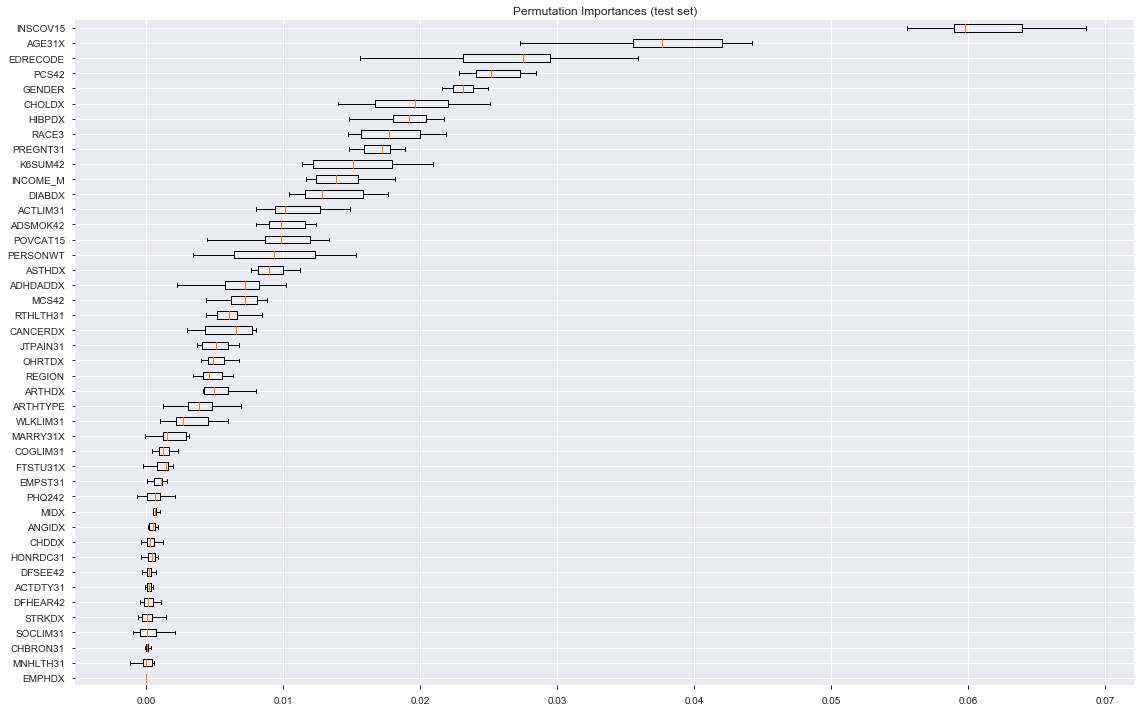

In [16]:
result = permutation_importance(model1, X_test1, y_test1, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(16,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test1.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Model 2: 
* zmienne kategoryczne - one-hot encoding
* zmienne ciągłe - standard scaler
* regressor - GBR
* zmienna uznana za istotną zmieniona na ciągłą - EDRECODE - poziom wykształcenia, wartosci (-1, 1, 2, 3, 13, 14, 15, 16) - im wyższe tym lepsze wykształcenie
* r2 = 0.377

In [17]:
categorical_features = ['REGION','MARRY31X','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15','RACE3','GENDER']

numerical_features= [feat for feat in df.columns if feat not in categorical_features]



numerical_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
regressor = GradientBoostingRegressor(n_estimators=300, random_state=42)
mdl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])

X_train2, X_test2, y_train2, y_test2 = train_test_split(df, y_log3, test_size=0.2, random_state=42)

mdl.fit(X_train2,y_train2)
y_pred = mdl.predict(X_test2)
print(r2_score(y_test2,y_pred))
model2 = mdl

0.3775401096547888


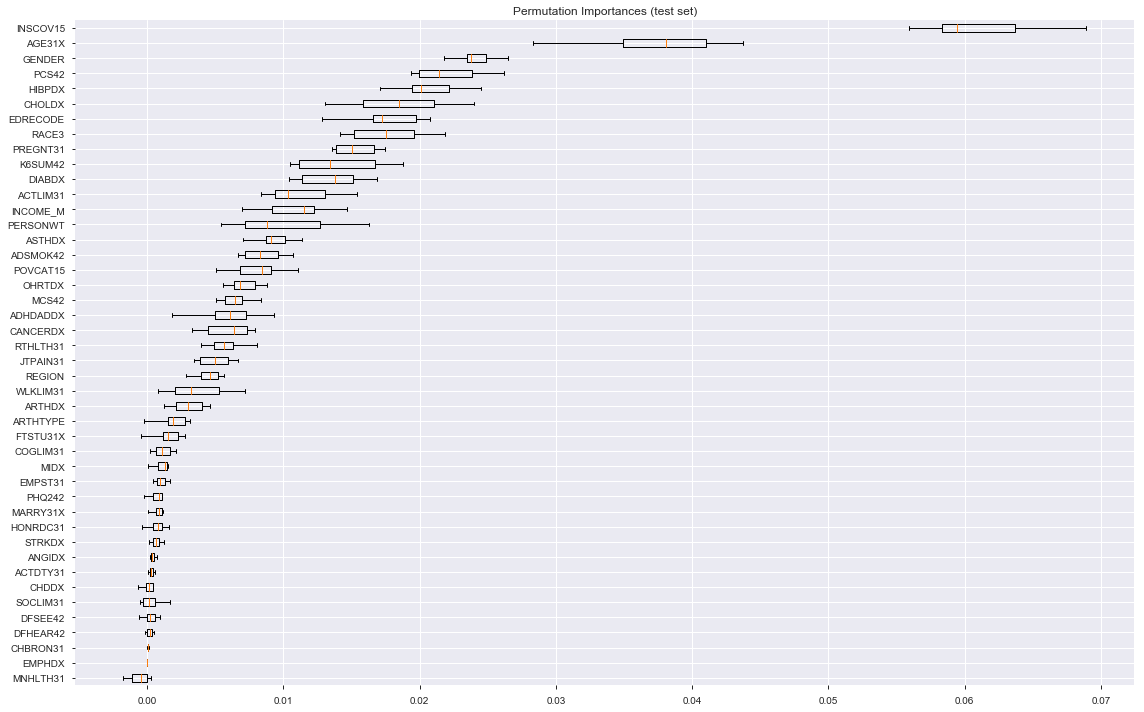

In [18]:
result = permutation_importance(model2, X_test2, y_test2, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(16,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test2.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Model 3: 
* zmienne kategoryczne - one-hot encoding
* zmienne ciągłe - minmaxscaler
* regressor - GBR
* wszystkie zmienne związane z diagnozą choroby (['HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHOLDX', 'CANCERDX', 'DIABDX', 'ARTHDX', 'ASTHDX', 'ADHDADDX']) zsumowane do jednej zmiennej 'ALL_DX' 
* r2 = 0.378

In [19]:
df_3 = df.copy()

In [20]:
cols = df.columns.to_list()

In [21]:
diag = [col for col in cols if 'DX' in col]

In [22]:
for col in diag:
    df_3[col] = df_3[col].apply(lambda x: x if x>=0 else 0) 
    df_3[col] = df_3[col].apply(lambda x: 0 if x==2 else 1) 

In [23]:
df_3[col].value_counts()

1    15320
0     3030
Name: ADHDADDX, dtype: int64

In [24]:
diag

['HIBPDX',
 'CHDDX',
 'ANGIDX',
 'MIDX',
 'OHRTDX',
 'STRKDX',
 'EMPHDX',
 'CHOLDX',
 'CANCERDX',
 'DIABDX',
 'ARTHDX',
 'ASTHDX',
 'ADHDADDX']

In [25]:
len(diag)

13

In [26]:
df_3['ALL_DX'] = df_3['HIBPDX'] + df_3['CHDDX'] + df_3['ANGIDX'] + df_3['MIDX'] + df_3['OHRTDX'] + df_3['STRKDX']\
                +df_3['EMPHDX'] + df_3['CHOLDX'] + df_3['CANCERDX'] + df_3['DIABDX'] + df_3['ARTHDX'] + df_3['ASTHDX'] + df_3['ADHDADDX']

In [27]:
df_3 = df_3.drop(columns=diag)

In [28]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_3, y_log3, test_size=0.2, random_state=42)

In [29]:
categorical_features = ['REGION','MARRY31X','FTSTU31X','ACTDTY31','HONRDC31',
            'RTHLTH31','MNHLTH31','HIBPDX','CHDDX','ANGIDX','MIDX','OHRTDX','STRKDX',
            'EMPHDX','CHBRON31','CHOLDX','CANCERDX','DIABDX','JTPAIN31','ARTHDX',
            'ARTHTYPE','ASTHDX','ADHDADDX','PREGNT31','WLKLIM31','ACTLIM31','SOCLIM31',
            'COGLIM31','DFHEAR42','DFSEE42','ADSMOK42','PHQ242','EMPST31','POVCAT15','INSCOV15','RACE3','GENDER']

In [30]:
categorical_features = [cat for cat in categorical_features if cat not in diag]

In [31]:
categorical_features

['REGION',
 'MARRY31X',
 'FTSTU31X',
 'ACTDTY31',
 'HONRDC31',
 'RTHLTH31',
 'MNHLTH31',
 'CHBRON31',
 'JTPAIN31',
 'ARTHTYPE',
 'PREGNT31',
 'WLKLIM31',
 'ACTLIM31',
 'SOCLIM31',
 'COGLIM31',
 'DFHEAR42',
 'DFSEE42',
 'ADSMOK42',
 'PHQ242',
 'EMPST31',
 'POVCAT15',
 'INSCOV15',
 'RACE3',
 'GENDER']

In [32]:
numerical_features= [feat for feat in df_3.columns if feat not in categorical_features]

In [33]:
numerical_features

['AGE31X',
 'EDRECODE',
 'PCS42',
 'MCS42',
 'K6SUM42',
 'INCOME_M',
 'PERSONWT',
 'ALL_DX']

In [35]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
regressor = GradientBoostingRegressor(n_estimators=300, random_state=42)
mdl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])
mdl.fit(X_train3,y_train3)
y_pred = mdl.predict(X_test3)
print(r2_score(y_test3,y_pred))
model3 = mdl

0.37783932569807765


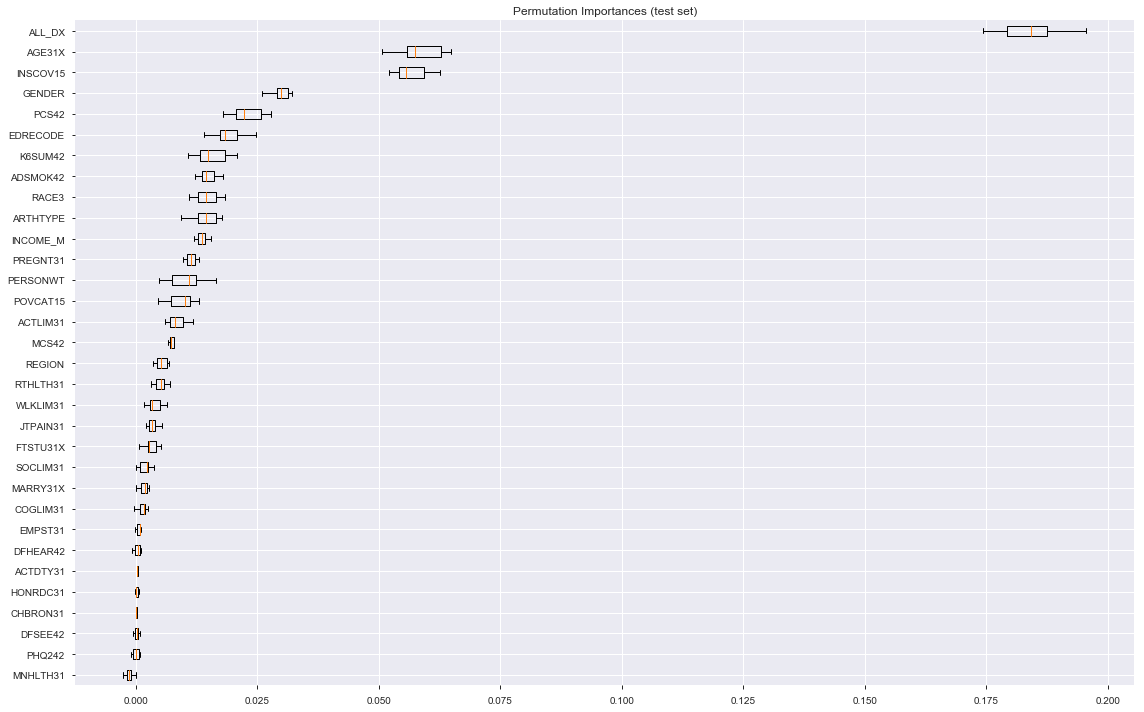

In [36]:
result = permutation_importance(model3, X_test3, y_test3, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(16,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test3.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

Model 4: 
* zmienne kategoryczne - one-hot encoding
* zmienne ciągłe - minmaxscaler
* regressor - regresja liniowa
* wszystkie zmienne związane z diagnozą choroby (['HIBPDX', 'CHDDX', 'ANGIDX', 'MIDX', 'OHRTDX', 'STRKDX', 'EMPHDX', 'CHOLDX', 'CANCERDX', 'DIABDX', 'ARTHDX', 'ASTHDX', 'ADHDADDX']) zsumowane do jednej zmiennej 'ALL_DX' 
* r2 = 0.338

In [37]:
df_4 = df_3.copy()
X_train4, X_test4, y_train4, y_test4 = X_train3.copy(), X_test3.copy(), y_train3.copy(), y_test3.copy()


In [40]:
numerical_transformer = Pipeline(
    steps=[
        ('scaler', MinMaxScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
regressor = LinearRegression()
mdl = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', regressor)])
mdl.fit(X_train4,y_train4)
y_pred = mdl.predict(X_test4)
print(r2_score(y_test4,y_pred))
model4 = mdl

0.3385851928617144


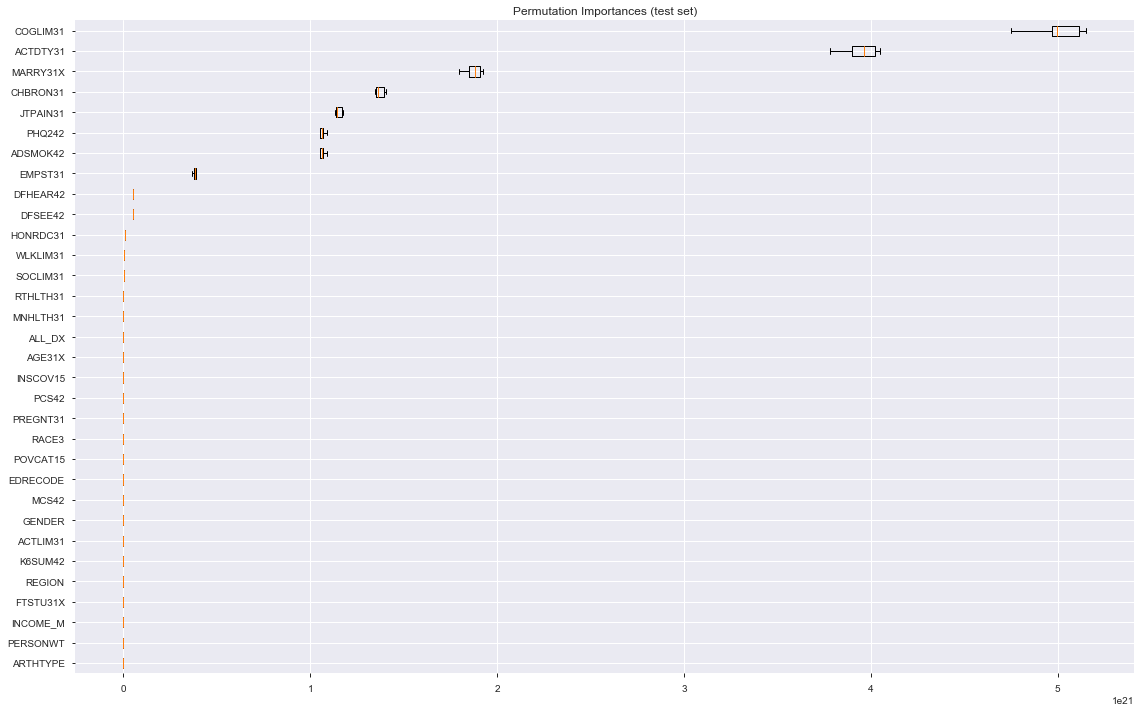

In [41]:
result = permutation_importance(model4, X_test4, y_test4, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
fig, ax = plt.subplots(figsize=(16,10))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test4.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()